In [6]:
from imagedaemon import registry
print("Registered cameras:", registry.available())

winter = registry.get("winter")
print("Winter camera:", winter)

print("Winter camera parameters:")
for entry in winter.meta:
    print(entry)

Registered cameras: ['winter']
Winter camera: <imagedaemon.cameras.winter.pipelines.WinterPipelines object at 0x1091dd990>
Winter camera parameters:
('name', 'winter')
('pixel_scale', 1.12)
('scale_margin', 0.05)
('sensors', ('pa', 'pb', 'pc', 'sa', 'sb', 'sc'))
('hot_pixel_threshold', 60000)
('cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': True, 'sky_flat': False, 'remove_horizontal_stripes': True, 'mask': True, 'mask_hot_pixels': True, 'replace_nans_with_median': True})
('dark_dir', PosixPath('/Users/nlourie/data/image-daemon-data/calibration/winter/masterdarks'))
('lab_flat_file', PosixPath('/Users/nlourie/data/image-daemon-data/calibration/winter/masterflats/masterflat.fits'))


In [7]:
from imagedaemon.pipelines.base import BasePipelines
from imagedaemon.cameras.winter.meta import WinterMeta

pipeline = BasePipelines(WinterMeta())   # note the () ← instantiate


In [8]:
# let's try to run the winter calibration pipeline
from imagedaemon.utils.paths import RAW_DATA_DIR
import os
from glob import glob

addr = "pc"


winter = registry.get("winter")

bkg_dir = os.path.join(RAW_DATA_DIR, "winter", "science", "30s", "bkg")
science_dir = os.path.join(RAW_DATA_DIR, "winter", "science", "30s")

bkg_images = sorted(glob(os.path.join(bkg_dir, "*mef.fits")))
MAX_BKG_IMAGES = 3

bkg_images = bkg_images[:MAX_BKG_IMAGES]
science_images = sorted(glob(os.path.join(science_dir, "*mef.fits")))
science_image = science_images[0]

use_science_in_bkg = True

if use_science_in_bkg:
    bkg_images = [science_image] + bkg_images
    print(f"Using {len(bkg_images)} background images with science image")
else:
    print(f"Using {len(bkg_images)} background images without science image")

calimg = winter.calibrate_image(addr = addr, 
                                 science_image = science_image, 
                                 background_image_list = bkg_images)

# try to save the calibrated image
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

# take a look at the header
#for card in calimg.header.cards:
#    print(card)

calimg.save_image(os.path.join(output_dir, "calibrated_img.fits"))

[I imagedaemon.pipeline] Calibration started | camera=winter image=/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/WINTERcamera_20250507-103738-584_mef.fits


Using 4 background images with science image


/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:78: RuntimeWarning: All-NaN slice encountered
  median_bkg = np.nanmedian(bkg_data, axis=0)
[I imagedaemon.camera.winter] Built dither flat from 4 frames  addr=pc
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: invalid value encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
[I imagedaemon.pipeline] Calibration started | camera=winter image=/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/WINTERcamera_20250507-103738-584_mef.fits
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:78: RuntimeWarning: All-NaN slice encountered
  median_bkg = np.nanmedian(bkg_data, axis=0)
[I imagedaemon.camera.winter] Built dither flat from 4 frames  addr=pc
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/processing/calibration.py:42: RuntimeWarning: invalid value encountered 

[astrometry] solve-field /Users/nlourie/data/tmp/WINTERcamera_20250507-103738-584_mef.cal.fits --scale-units arcsecperpix --scale-low 1.064 --scale-high 1.1760000000000002 --ra 269.9242812438885 --dec 44.1886916504314 --radius 2.0 --downsample 2 --overwrite

Reading input file 1 of 1: "/Users/nlourie/data/tmp/WINTERcamera_20250507-103738-584_mef.cal.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/tmp/WINTERcamera_20250507-103738-584_mef.cal.fits --uncompressed-outfile /tmp/tmp.uncompressed.L4nTzi --outfile /tmp/tmp.ppm.qYqJyw --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 1495 sources.
Making source extraction overlay plot -- pnmfn = /tmp/tmp.ppm.qYqJyw
Solving...
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_codes" in file "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits"
index.c:329:index_reload: Failed to read star kdtree from file /opt/homebrew/Cellar/astrometry-

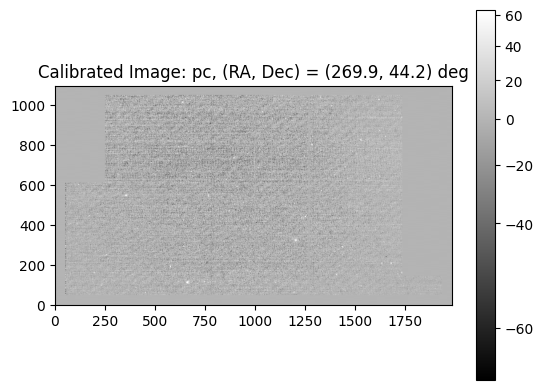

In [9]:


# plot the calibrated image!
ra_guess, dec_guess = calimg.header["RADEG"], calimg.header["DECDEG"]
calimg.plot_image(title = f"Calibrated Image: {addr}, (RA, Dec) = ({ra_guess:.1f}, {dec_guess:.1f}) deg",)


# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))
wcs = winter.get_astrometric_solution(addr = addr,
                                      science_image = science_image,
                                      background_image_list = bkg_images,
                                      output_dir = output_dir,
    )



In [10]:
# report back the RA/Dec of a specified pixel location
x_pix, y_pix = 1950, 550

from imagedaemon.utils.wcs_utils import pix2sky
sky_pos = pix2sky(x_pix, y_pix, wcs)
print(
    f"Coord conversion: (x, y) = ({x_pix}, {y_pix}) -> (RA, Dec) = ({sky_pos.ra:.1f}, {sky_pos.dec:.1f}) deg"
)

# print it back in DS9 format
print(
    f"Pixel coords: (x, y) = ({x_pix:.1f}, {y_pix:.1f}) -> (x, y) = ({sky_pos.to_string('hmsdms', precision=2)}, {sky_pos.to_string('hmsdms', precision=2)})"
)


Coord conversion: (x, y) = (1950, 550) -> (RA, Dec) = (269.9 deg, 44.6 deg) deg
Pixel coords: (x, y) = (1950.0, 550.0) -> (x, y) = (17h59m42.55s +44d38m16.06s, 17h59m42.55s +44d38m16.06s)
